In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import missingno as msno
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score,roc_auc_score, roc_curve
from stepwise_regression.step_reg import forward_regression
from sklearn.base import clone
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

##  Preparing data for analysis

In [4]:
loan = pd.read_csv('loan-train.csv') #load data into a pandas dataframe
loan.head() #print the first 5 rows

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
loan.shape #check the shape of the data

(614, 13)

In [6]:
loan.columns #a summary of the columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [7]:
loan.dtypes #datatypes of the columns

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [8]:
loan.isna().sum() #sum of missing values in columns

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

##  Exploratory Data Analysis

In [10]:
loan.describe()#a summary statistics of the data to identify similarities and anomalities

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


 The std for the numerical values [ApplicantIncome, CoapplicantIncome, LoanAmount and Loan_Amount_Term] are relatively high and such outliers would
 such outliers would likely affect models that are not robust to outliers. the min for these columns are also very low with very high max values. this suggest the presence of outliers

#### Univariant analysis - insights on one variable

<Axes: xlabel='ApplicantIncome', ylabel='Count'>

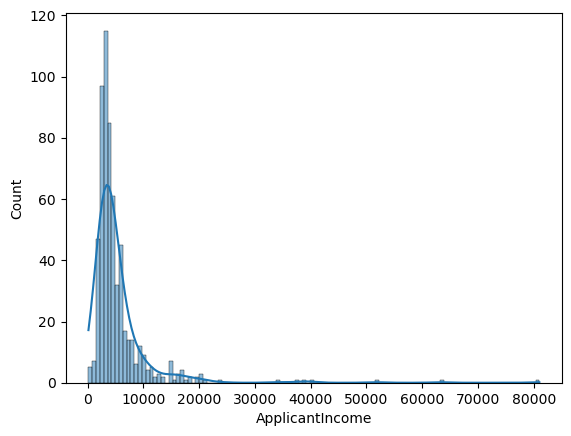

In [13]:
sns.histplot(loan['ApplicantIncome'], kde=True) #Applicant income distribution

This graph shows a right-skewed (positive) distribution. The majority of the income of the individuals are concetrated at the lower range of 0-10000.
There are very few of the incomes spanning towards the right showing higher income. These high incomes could have an impact on the mean and analysis.
Scaling the values could help in analysis and model predictions.
The graph shows that generally, most loan applicants have low to moderate incomes and very view with high incomes

<Axes: xlabel='CoapplicantIncome', ylabel='Count'>

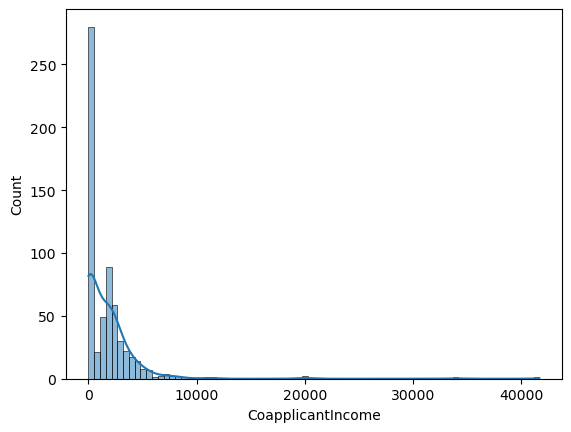

In [15]:
sns.histplot(loan['CoapplicantIncome'], kde=True) #CoApplicant income distribution

This gragh of coapplicant income is rightly skewed shoing a concentration of the incomes of co applicants to range from 0-10000, suggesting low incomes.
There are a few incomes spanning up to 40,000. This hints they may be outliers and would need further processing to to measure their impact on the data. 

<Axes: xlabel='LoanAmount', ylabel='Count'>

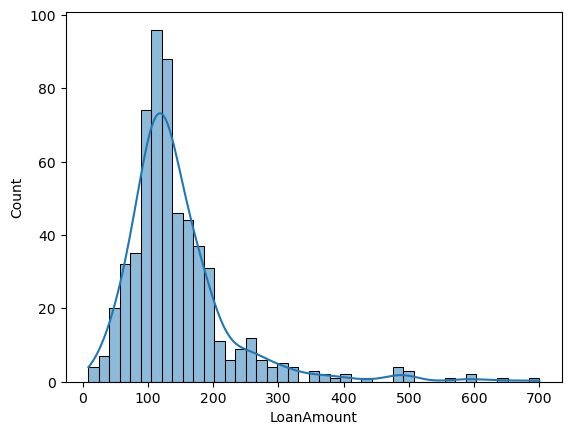

In [17]:
sns.histplot(loan['LoanAmount'], kde=True)#ALoan amount distribution

This distribution is slightly skewed to the right. Most of the amounts are concentrated between 100 and 200 showing that thats the most frequesnt loan amounts given. the loan amounts exceeding 500 indicates that givin larger amounts of loan is not very typical.

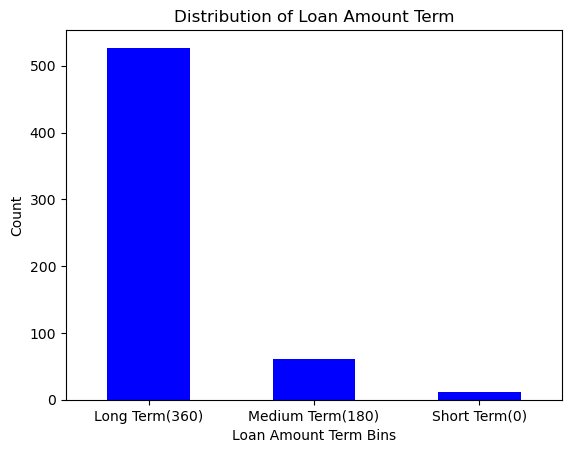

In [19]:
# Define bins and labels
loan_amount_term_bins = [0, 180, 360, float('inf')]
loan_amount_term_labels = ['Short Term(0)', 'Medium Term(180)', 'Long Term(360)']

# Create binned column
loan['LoanAmountTerm_Binned'] = pd.cut(loan['Loan_Amount_Term'], bins=loan_amount_term_bins, labels=loan_amount_term_labels, right=False)

loan_amount_term_counts = loan['LoanAmountTerm_Binned'].value_counts()

# bar chart for loan amount term distribution
loan_amount_term_counts.plot(kind='bar', color='blue')
plt.title('Distribution of Loan Amount Term')
plt.xlabel('Loan Amount Term Bins')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The most frequesnt loan amount term is 360 months with very few being 180 months and lesser. The dominance of the 360-month term suggests a pattern where 30-year loans are the standard.

#### bi-variant analysis

<Axes: xlabel='Loan_Status', ylabel='Loan_Amount_Term'>

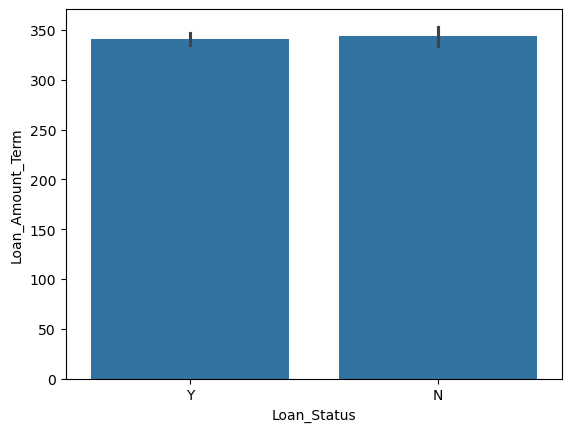

In [22]:
sns.barplot(x='Loan_Status', y='Loan_Amount_Term', data=loan) #relationship between loan status and credit history

The lenght of the period for which the loan is given does not have an impact on the status of the next loan

<Axes: xlabel='Loan_Status', ylabel='Credit_History'>

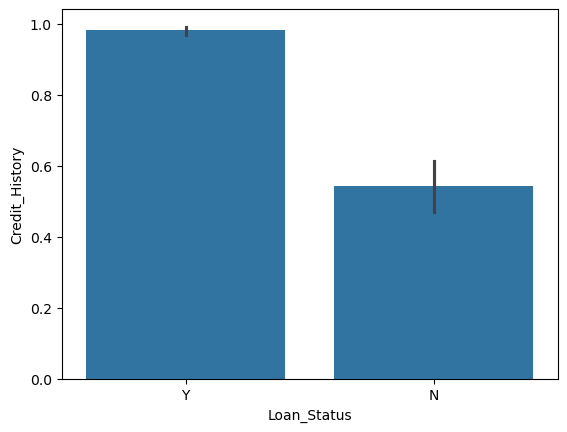

In [24]:
sns.barplot(x='Loan_Status', y='Credit_History', data=loan) #relationship between loan status and credit history

The bar chart shows that individuals with a good credit history are more likely to have their loans approved.
There is a notable gap between the approval rates for those with a good credit history compared to those without it, emphasizing that credit history is important in the approval process.

<Axes: xlabel='Loan_Status', ylabel='ApplicantIncome'>

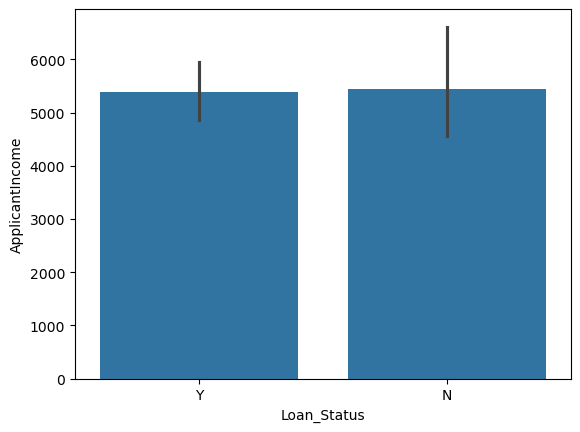

In [26]:
 sns.barplot(x='Loan_Status', y='ApplicantIncome', data=loan) #relationship between loan status and credit Applicant income

There is not much difference between the different incomes and their loans being approved. This suggest that, loans getting approve does not depend on the applicants incomes as incomes of all ranges get approved or rejected

<Axes: xlabel='Loan_Status', ylabel='ApplicantIncome'>

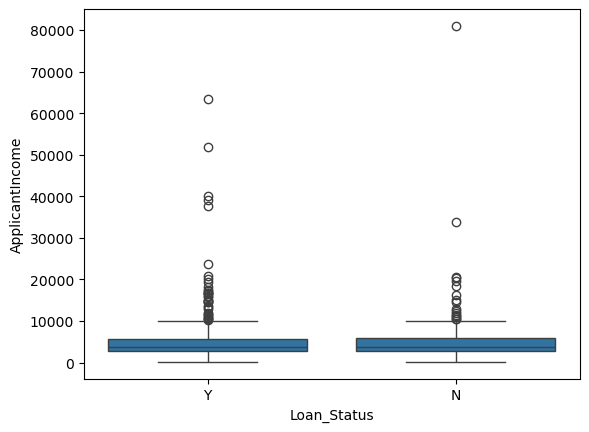

In [28]:
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=loan) #detecting outliers in Applicant income

The plot shows a large range of applicant incomes, with outliers on the higher end for both approved and rejected loans.
Most applicants, regardless of loan status, have similar median incomes, with income distributions heavily concentrated in the lower ranges.
Outliers suggest there are some applicants with very high incomes whose loans were still rejected, indicating that other factors such as credit history likely played a role.

<Axes: xlabel='Loan_Status', ylabel='Dependents'>

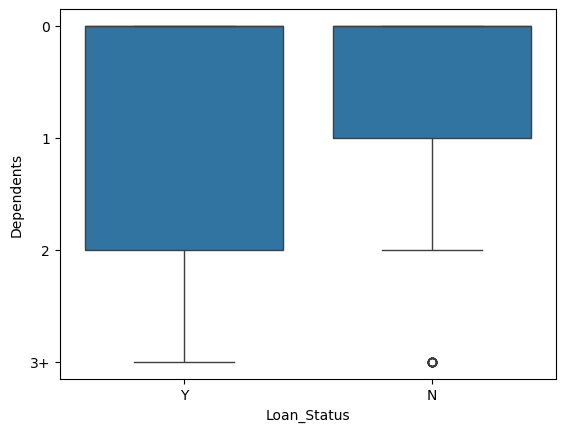

In [30]:
sns.boxplot(x='Loan_Status', y='Dependents', data=loan)#detecting outliers and relationship between dependents and loan status

Most applicants with approved loans have fewer dependents. Applicants with approved loans have a wider spread of dependents, but applicants with more than 2 dependents still appear to have loans approved, but less frequently.

The median number of dependents for applicants with rejected loans is slightly higher compared to approved loans. There are fewer applicants with 3+ dependents in the rejected category, but one notable outlier is present, possibly indicating exceptional cases.

The number of dependents seems to have a mild influence on loan approval. Applicants with fewer dependents are more likely to get their loans approved, which may reflect financial stability or better repayment capacity.


#### Multi-variant analysis

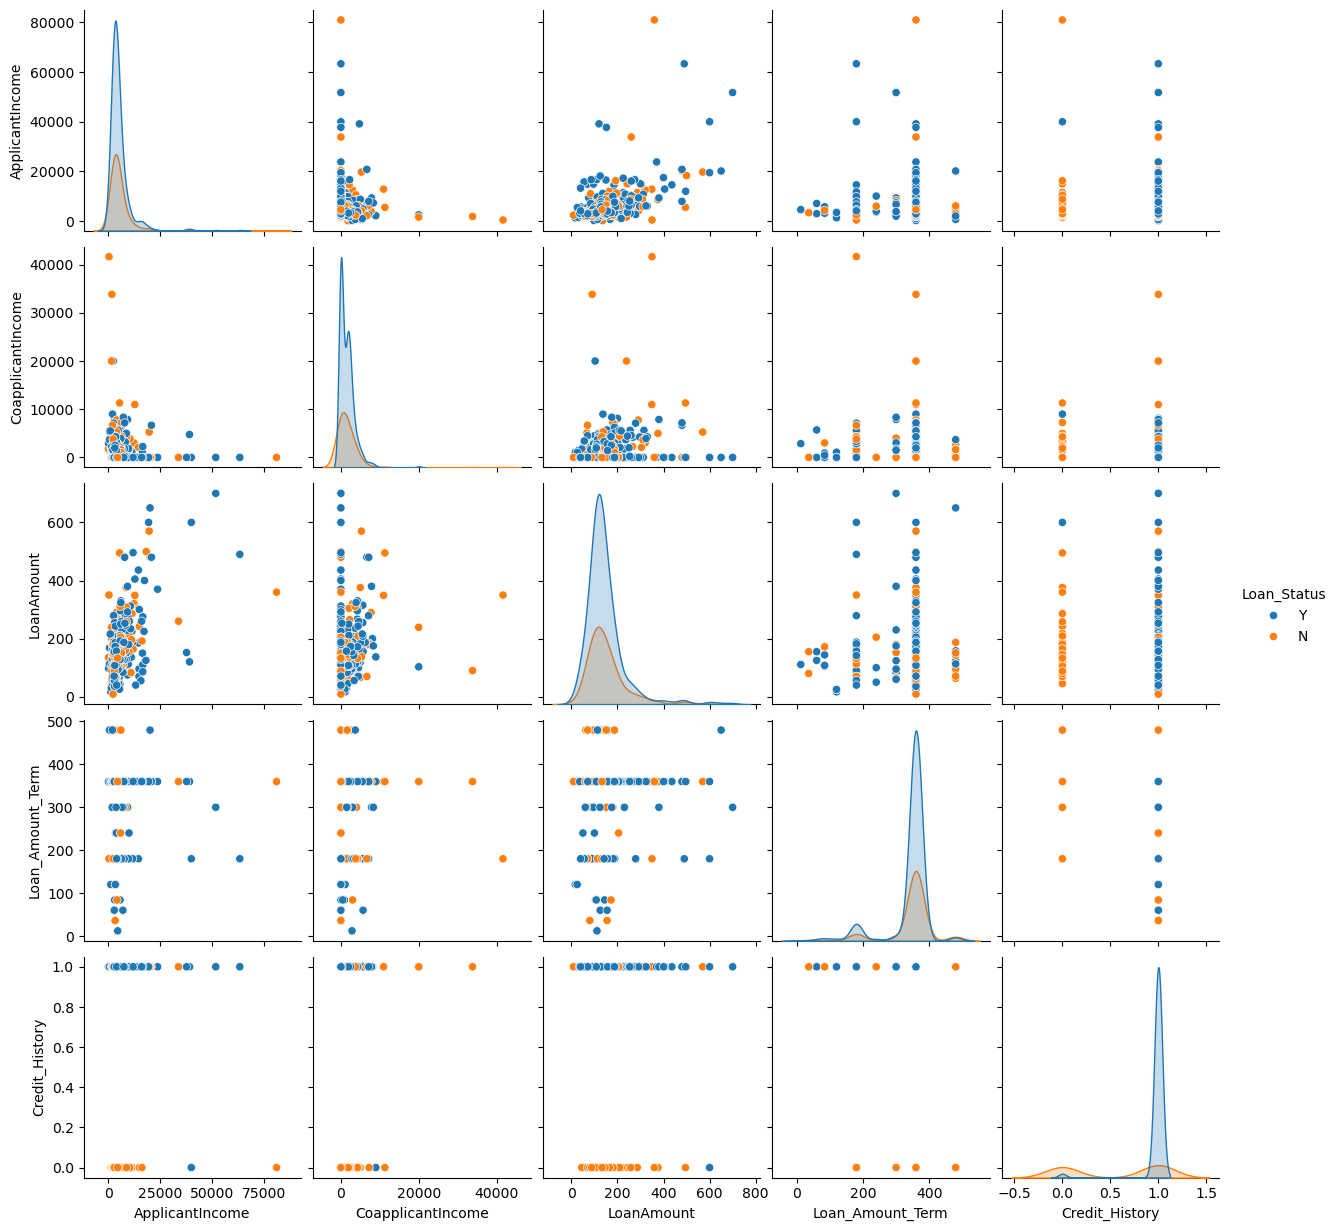

In [33]:
sns.pairplot(loan.iloc[:,:], hue='Loan_Status') #relationship between nemerical features and loan status

From this plot:
The distribution of ApplicantIncome is highly skewed, with a majority of the data points clustered at lower income levels as already shown in earlier plot
Loans are approved and rejected across a range of CoapplicantIncome, though very high coapplicant incomes appear rare.
LoanAmount distributions are slightly less skewed compared to incomes.
Approved loans and rejected loans occur across a range of loan amounts, but there is a notable concentration of both approvals and rejections at smaller loan amounts.
The loan term has clear categorical values (e.g., 360, 180 months), with a majority of data points around these standard terms. Loan approvals and rejections are evenly distributed across the common loan term durations.
Credit history shows a significant relationship with Loan_Status.
Applicants with Credit_History = 1 (indicating a positive credit history) are more likely to have their loans approved.
Applicants with Credit_History = 0 are predominantly associated with loan rejections. the most significant predictors.

<Axes: >

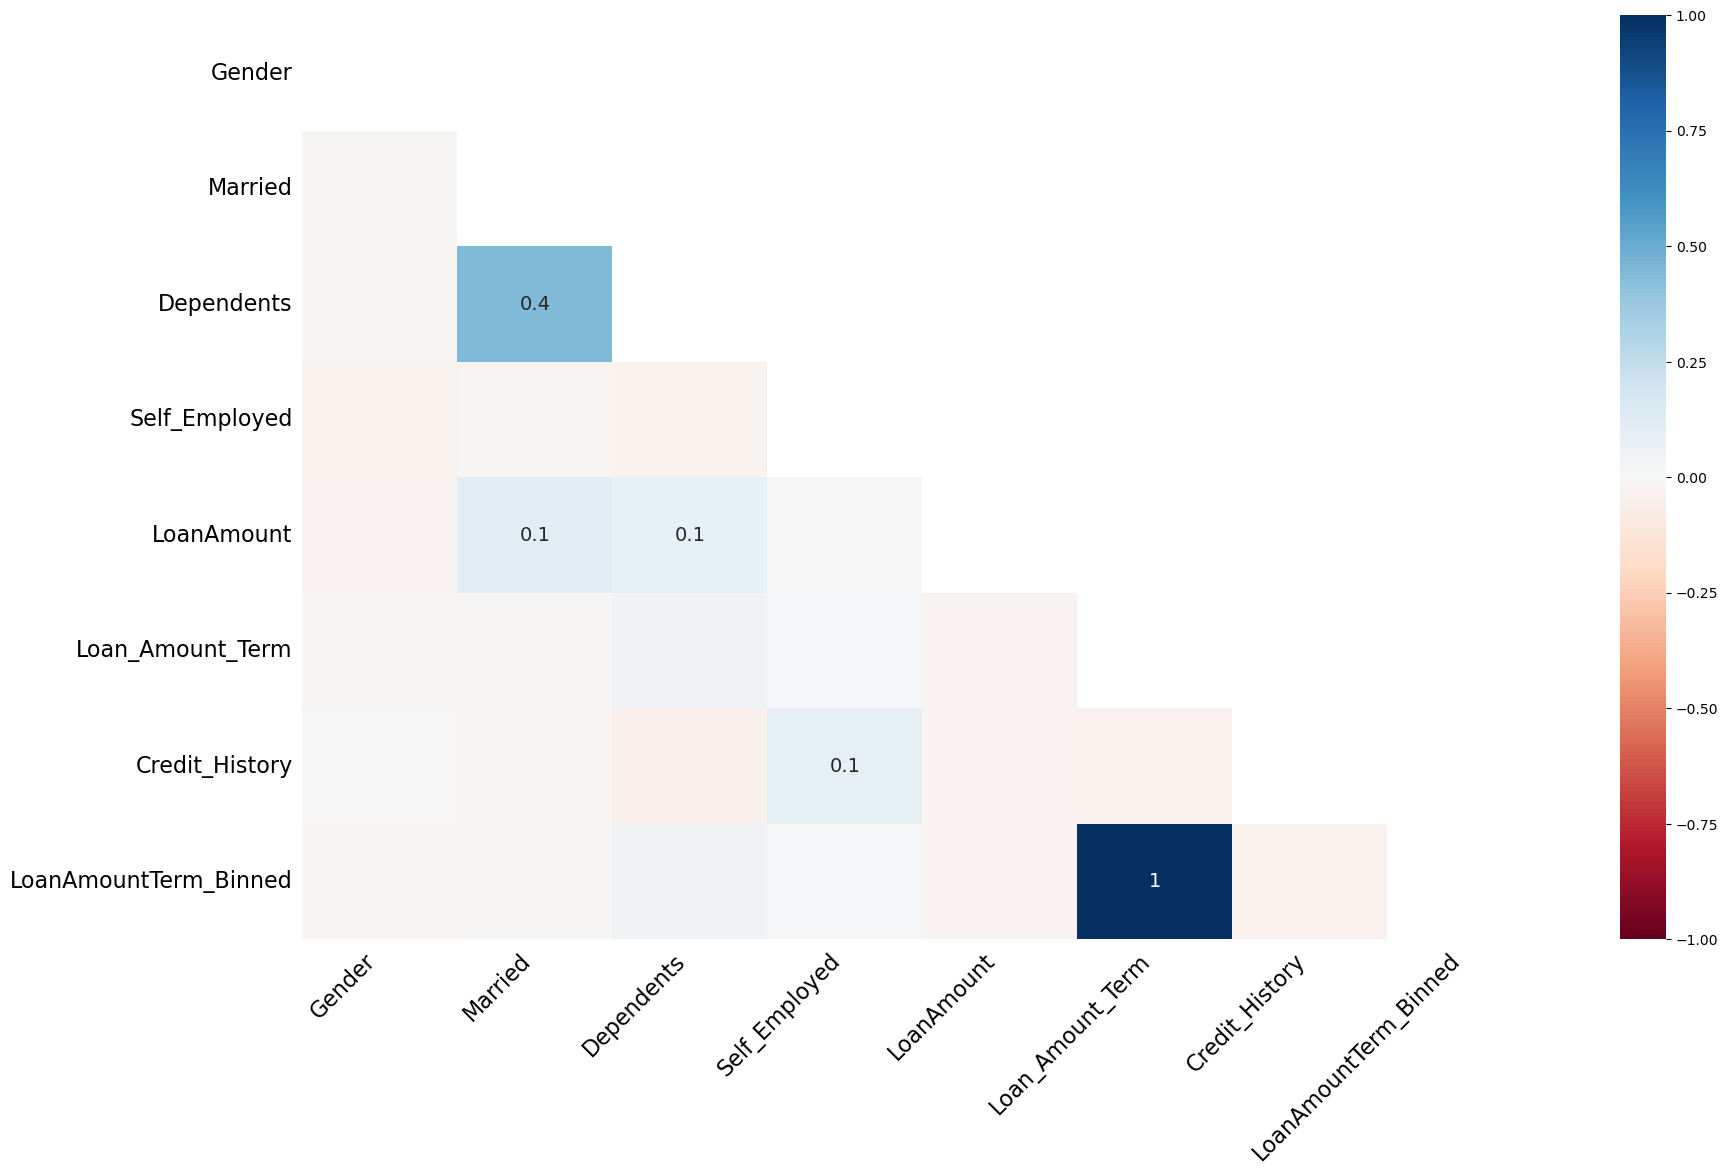

In [35]:
msno.heatmap(loan)#missing values

The darker shades in the heatmap (e.g., at "Dependents" and "Married") represent cells with missing values.
For the Dependents, there appears to be a moderate percentage of missing data (indicated by the lighter shade in correlation with Married).
Features like Loan_Amount_Term_Binned and Credit_History show little to no missing data, as they are consistently dark blue (indicating full data availability).


Features with significant missing values may need imputation or other techniques for handling missing data.


#  Data preprocessing

In [38]:
loan.isna().sum()#checkinf for null values

Loan_ID                   0
Gender                   13
Married                   3
Dependents               15
Education                 0
Self_Employed            32
ApplicantIncome           0
CoapplicantIncome         0
LoanAmount               22
Loan_Amount_Term         14
Credit_History           50
Property_Area             0
Loan_Status               0
LoanAmountTerm_Binned    14
dtype: int64

Gender, Married, Dependent, and Self-Employed columns are categorical with missing values. The missing values will be filled with the value in the column that appears the most(mode). Filling missing values with the mode helps maintain the dominant pattern in the data, ensuring the imputed values are consistent with the majority of the existing data. As already seen from the visualizations, there's a wide difference between the most frequest values from the rest. Using the mode will maintain such difference.

In [40]:
#filling null values in categorical columns with mode
loan['Gender']=loan['Gender'].fillna(loan['Gender'].mode()[0])
loan['Married']=loan['Married'].fillna(loan['Married'].mode()[0])
loan['Dependents']=loan['Dependents'].fillna(loan['Dependents'].mode()[0])
loan['Self_Employed']=loan['Self_Employed'].fillna(loan['Self_Employed'].mode()[0])

In [41]:
loan.isna().sum() #checking for null values

Loan_ID                   0
Gender                    0
Married                   0
Dependents                0
Education                 0
Self_Employed             0
ApplicantIncome           0
CoapplicantIncome         0
LoanAmount               22
Loan_Amount_Term         14
Credit_History           50
Property_Area             0
Loan_Status               0
LoanAmountTerm_Binned    14
dtype: int64

In [42]:
#checking the values of the data in the loan amount term column. 
#this consists of how long the previous loan has been given

loan['Loan_Amount_Term'].value_counts()

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

This column will be filled with the most occuring term as seen in the visualization, the most common term period for loans is 360. Taking the mean will likely result in a new values that is not particular with loan periods

In [44]:
#filling null values with 360 - most frequesnt loan term
loan['Loan_Amount_Term']=loan['Loan_Amount_Term'].fillna(loan['Loan_Amount_Term'].mode()[0])

In [45]:
#this column contains 0 and 1
# 0 represent people that do not have a positive credit history
# 1 represents people that have a positive test history
loan['Credit_History'].value_counts()

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

As seen here too, there is a clear difference between the two values with majority having a good credit score. Taking an average would result in a new value that is not easy to interpret. Using the mode value here wpuld be ideal to maintain the balance in the dataset.

In [47]:
#filling null values with mode
loan['Credit_History']=loan['Credit_History'].fillna(loan['Credit_History'].mode()[0])

In [48]:
# this column contains the amounts that have been loaned to the individuals. 
# there are so many different records and the amount vary as people request differnt amount based on their needs
loan['LoanAmount'].value_counts()

LoanAmount
120.0    20
110.0    17
100.0    15
160.0    12
187.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: count, Length: 203, dtype: int64

The values here represent the amount of money given as loans to people. loans are based on certain factors and they may vary from person to person as seen that the is a wide range of amounts, Using the average would be ideal in this case.

In [50]:
#the null values are filled with the average of the loan amounts
loan['LoanAmount']=loan['LoanAmount'].fillna(loan['LoanAmount'].mean())

In [51]:
loan.isna().sum()# checking for any more null values

Loan_ID                   0
Gender                    0
Married                   0
Dependents                0
Education                 0
Self_Employed             0
ApplicantIncome           0
CoapplicantIncome         0
LoanAmount                0
Loan_Amount_Term          0
Credit_History            0
Property_Area             0
Loan_Status               0
LoanAmountTerm_Binned    14
dtype: int64

In [52]:
#dropping the loan amount tern binned column since it was only used to aid with a visualization
loan = loan.drop('LoanAmountTerm_Binned', axis=1)

After filling the null values, the categorical values can then be encoded to numerical to be used for analysis

In [54]:
encoder=LabelEncoder()
loan['Gender']=encoder.fit_transform(loan['Gender'])
loan['Married']=encoder.fit_transform(loan['Married'])
loan['Education']=encoder.fit_transform(loan['Education'])
loan['Self_Employed']=encoder.fit_transform(loan['Self_Employed'])
loan['Property_Area']=encoder.fit_transform(loan['Property_Area'])
loan['Loan_Status']=encoder.fit_transform(loan['Loan_Status'])
loan

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,0,0,0,0,2900,0.0,71.000000,360.0,1.0,0,1
610,LP002979,1,1,3+,0,0,4106,0.0,40.000000,180.0,1.0,0,1
611,LP002983,1,1,1,0,0,8072,240.0,253.000000,360.0,1.0,2,1
612,LP002984,1,1,2,0,0,7583,0.0,187.000000,360.0,1.0,2,1


In [55]:
loan.dtypes #checking datatypes after encoding

Loan_ID               object
Gender                 int32
Married                int32
Dependents            object
Education              int32
Self_Employed          int32
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int32
Loan_Status            int32
dtype: object

In [56]:
loan['Dependents'].value_counts() #checking the unique values in dependents column

Dependents
0     360
1     102
2     101
3+     51
Name: count, dtype: int64

3+ indicates people with 3 or more dependants. In this case, it can be considered that dependents from 3 upwards would be treated the same way.
3 is the threshold 

In [58]:
# covert all 3+ to 3 since that serves as the threshold
loan['Dependents']=loan['Dependents'].replace('3+','3')

In [59]:
loan['Dependents'].value_counts()#checking the values in the dependents column to confirm changes

Dependents
0    360
1    102
2    101
3     51
Name: count, dtype: int64

In [60]:
loan['Dependents']=pd.to_numeric(loan['Dependents']) #converting the dependents column to numerical

In [61]:
loan.info()# confirmimg that the entire data is now made of numerical values with no null values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    int32  
 2   Married            614 non-null    int32  
 3   Dependents         614 non-null    int64  
 4   Education          614 non-null    int32  
 5   Self_Employed      614 non-null    int32  
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    int32  
 12  Loan_Status        614 non-null    int32  
dtypes: float64(4), int32(6), int64(2), object(1)
memory usage: 48.1+ KB


In [62]:
# the load_id column is just a unique value to represent the individual enteries and does not contribute to the outcome of the loan
loan['Loan_ID'].value_counts()

Loan_ID
LP001002    1
LP002328    1
LP002305    1
LP002308    1
LP002314    1
           ..
LP001692    1
LP001693    1
LP001698    1
LP001699    1
LP002990    1
Name: count, Length: 614, dtype: int64

In [63]:
#dropping the Loan_id column
loan= loan.drop('Loan_ID', axis=1)

In [64]:
corr = loan.corr()#finding the correlation between all columns ad loan status

<Axes: >

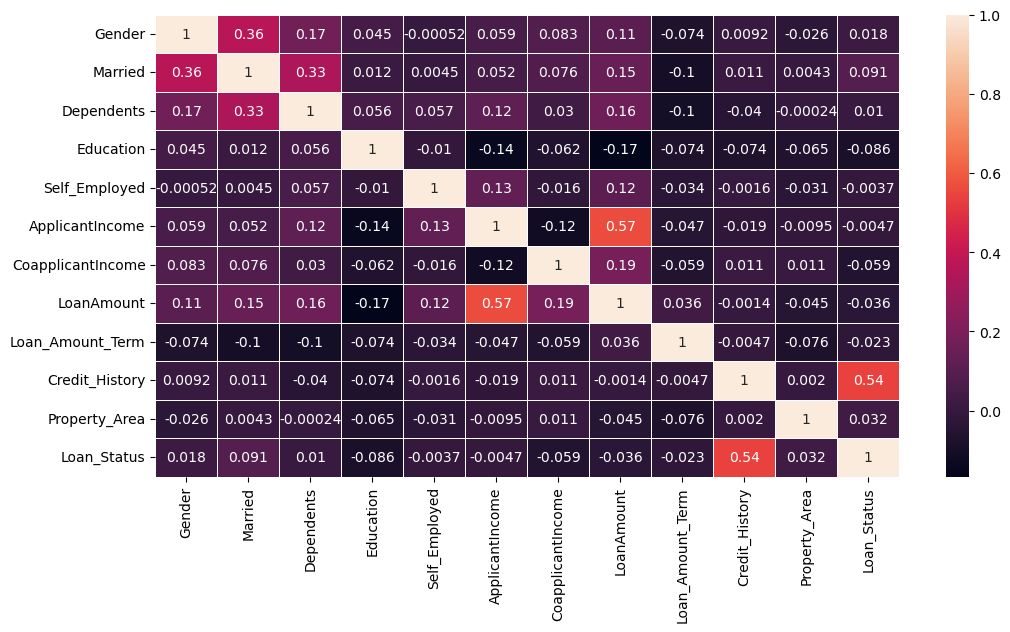

In [65]:
plt.figure(figsize=(12, 6)) #visualizing the correlation
sns.heatmap(corr, annot=True, linewidth=.5)

In respect to the loan status, it can be seen that credit_History is has the highest impact on the status on the loan which makes sense since having a good score shows your commitment to paying back loans. Gender, Mariied, Dependents, and property area have a very week positive correlation with the loan status showing that they contribute little to no significa in determining to give a loan or not. the rest of the features negatively correlate with the loan status shpwing they have no significance in the loan status.

#### Handling outliers

From the visualizations seen, outliers in the applicant income and coapplicant income are very huge. Using a logarithmic scale compresses the range, especially at the higher end, making the data less sensitive to extreme values and reducing the impact of the ouliers. It was also seen that those outliers do not really have an impact on the whether a loan is approved or not. using this scale helps with data that is highly skewed and can help to make it look normally distributed. The loan term does not also have an impact on the loan approval and has extreme values.

In [69]:
loan['Log_applicantIncome'] = np.log1p(loan['ApplicantIncome'])
loan['Log_CoapplicantIncome'] = np.log1p(loan['CoapplicantIncome'])
loan['Log_loanTerm'] = np.log1p(loan['Loan_Amount_Term'])
loan['Log_loanAmount'] = np.log1p(loan['LoanAmount'])

In [70]:
#drop the initial columns with huge outliers
loan = loan.drop(['ApplicantIncome','CoapplicantIncome', 'Loan_Amount_Term', 'LoanAmount'], axis = 1)


In [71]:
loan.describe()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,Log_applicantIncome,Log_CoapplicantIncome,Log_loanTerm,Log_loanAmount
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.817590,0.653094,0.744300,0.218241,0.133550,0.855049,1.037459,0.687296,8.341510,4.290129,5.806547,4.870872
std,0.386497,0.476373,1.009623,0.413389,0.340446,0.352339,0.787482,0.463973,0.645035,3.875873,0.309785,0.491376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.017280,0.000000,2.564949,2.302585
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.965024,0.000000,5.888878,4.617584
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,8.246303,7.081125,5.888878,4.867534
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,8.664922,7.739897,5.888878,5.110477
max,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,11.302217,10.637489,6.175867,6.552508


The data looks balanced with no extreme values

<Axes: xlabel='Log_applicantIncome', ylabel='Count'>

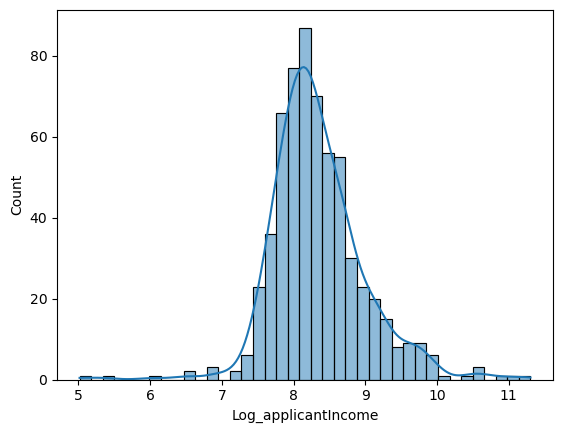

In [73]:
sns.histplot(loan['Log_applicantIncome'], kde=True)#checking the new distribution of the applicant income

<Axes: xlabel='Log_loanAmount', ylabel='Count'>

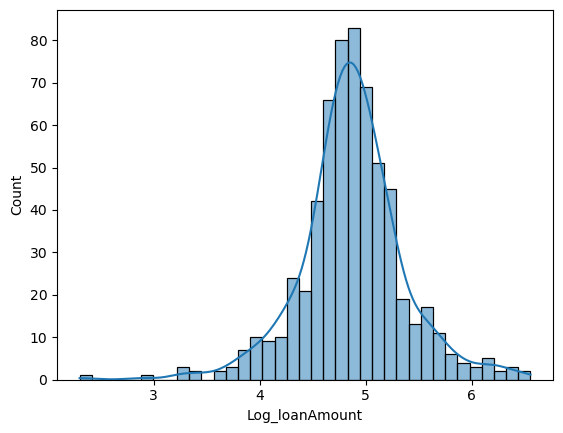

In [74]:
sns.histplot(loan['Log_loanAmount'], kde=True)#checking the new distribution of the loan applicant income

In [75]:
X = loan.drop('Loan_Status', axis=1)#set input data
y = loan['Loan_Status']#set output data

In [77]:
#logistic regression - eager learner
log = LogisticRegression()
#Random forest classifier - Ensemble method
rand = RandomForestClassifier(n_estimators=33)
#K-nearest neighbor - lazy learner
knn = KNeighborsClassifier(n_neighbors=5)
#naive baiyes - Probabilistic Learner
nb = GaussianNB()
#ANN- MLPClassifier
mlp = MLPClassifier(max_iter=300, hidden_layer_sizes=(10, 4), solver='lbfgs', activation='relu', batch_size=32)

models = [("Logistic Regression", log),
          ("Random Forest", rand),
          ("K-Nearest Neighbors", knn),
          ("Naive Bayes", nb),
           ("Multi Layer Perceptron", mlp)]

In [78]:
def comparing_models(X, y, models):
    """
    Compares different machine learning models based on accuracy, AUC scores, 
    and their ROC curves using Stratified K-Fold cross-validation.

    Parameters:
    -----------
    X : pandas.DataFrame or numpy.ndarray
        The input feature dataset.
    y : pandas.Series or numpy.ndarray
        The target labels corresponding to the input data.
    models : list of tuples
        A list of tuples where each tuple contains:
        - The model name (str): A label describing the model (e.g., "Logistic Regression").
        - The model object: An instance of a scikit-learn estimator (e.g., `LogisticRegression()`).

    Returns:
    --------
    model_accuracies : dict
        A dictionary containing the mean accuracy scores for each model. 
        Keys are model names, and values are mean accuracy scores.
    model_auc_scores : dict
        A dictionary containing the mean AUC (Area Under Curve) scores for each model. 
        Keys are model names, and values are mean AUC scores.
    model_fpr_tpr : dict
        A dictionary containing the false positive rates (FPR) and true positive rates (TPR) 
        for the ROC curve of each model. 
        Keys are model names, and values are tuples of (FPR, TPR).

    Functionality:
    --------------
    - Uses Stratified K-Fold cross-validation with 10 splits to ensure an even distribution of classes.
    - For each model:
        1. Clones the model to ensure a fresh base model for each fold.
        2. Computes mean accuracy using cross_val_score.
        3. Computes mean AUC using `cross_val_score`.
        4. Calculates the FPR and TPR for the ROC curve based on one fold (last fold or first fold).
    - Returns three dictionaries for accuracy, AUC scores, and FPR/TPR (used for visualization).

    """
    # Lists to store performance metrics
    model_accuracies = {}
    model_auc_scores = {}
    model_fpr_tpr = {}

    # Define Stratified K-Fold with 10 splits
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    for name, model in models:
        # Clone the model to ensure a fresh instance
        model_clone = clone(model)

        # Compute mean accuracy using cross-validation
        accuracy_scores = cross_val_score(model_clone, X, y, cv=cv, scoring='accuracy')
        model_accuracies[name] = accuracy_scores.mean()
        
        # Compute mean AUC using cross-validation
        auc_scores = cross_val_score(model_clone, X, y, cv=cv, scoring='roc_auc')
        model_auc_scores[name] = auc_scores.mean()
        
        # Compute ROC curve (FPR and TPR) for one fold
        fpr, tpr = None, None
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Train the model
            model_clone.fit(X_train, y_train)
            
            # Predict probabilities for the positive class
            y_pred_proba = model_clone.predict_proba(X_test)[:, 1]
            
            # Compute ROC curve for the fold
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            break  # Break after the first fold
            
        model_fpr_tpr[name] = (fpr, tpr)

    return model_accuracies, model_auc_scores, model_fpr_tpr


model_accuracies, model_auc_scores, model_fpr_tpr = comparing_models(X,y,models)

In [79]:
#create a dataframe with the accuracies computed
data = pd.DataFrame({
    "Model": [name for name, model in models],
    "Accuracy": list(model_accuracies.values()),
    "AUC Score": list(model_auc_scores.values())
})
data

,Model,Accuracy,AUC Score
0,Logistic Regression,0.809439,0.728935
1,Random Forest,0.789873,0.744988
2,K-Nearest Neighbors,0.729773,0.684254
3,Naive Bayes,0.799656,0.700568
4,Multi Layer Perceptron,0.793310,0.661187


In [80]:
def plot_bar(data):
    """
    Plots a bar chart comparing Accuracy and AUC Score for different models.

    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe should contain the following columns:
        - "Model": Names or labels of the models (x-axis).
        - "Accuracy": Accuracy scores for the models.
        - "AUC Score": Area Under the Curve (AUC) scores for the models.

    Returns:
    --------
    None
        Displays a bar plot comparing Accuracy and AUC Score for each model.

    Functionality:
    --------------
    - Plots two sets of bars (Accuracy and AUC Score) for each model side by side.
    - Adds labels, title, and legend for easy interpretation.
    - Dynamically calculates the y-axis limits with a small margin for better visualization.
    - Adjusts the plot size and layout for clarity and readability.
    - Models on the x-axis are rotated slightly for better visibility.

    """
    bar_width = 0.35  # Width of each bar
    index = np.arange(len(data))  # Positions of the models on the x-axis

    plt.figure(figsize=(10, 6))  # Set plot size
    # Plot Accuracy bars
    plt.bar(index, data["Accuracy"], bar_width, label="Accuracy", color="blue")
    # Plot AUC Score bars
    plt.bar(index + bar_width, data["AUC Score"], bar_width, label="AUC Score", color="red")

    # Dynamically determine y-axis limits
    y_min = min(data[["Accuracy", "AUC Score"]].min()) - 0.01  # Add some padding below
    y_max = max(data[["Accuracy", "AUC Score"]].max()) + 0.05  # Add some padding above

    # Add labels, title, and legend
    plt.xlabel("Models", fontsize=12)
    plt.ylabel("Scores", fontsize=12)
    plt.title("Model Performance Comparison (Accuracy vs AUC Score)", fontsize=14)
    plt.xticks(index + bar_width / 2, data["Model"], rotation=45, ha="right")
    plt.ylim(y_min, y_max)  # Set y-axis limits
    plt.legend(fontsize=10)

    # Adjust layout to avoid clipping
    plt.tight_layout()
    plt.show()


In [81]:
def plot_roc(auc_scores, fpr_tpr):
    """
    Plots the Receiver Operating Characteristic (ROC) curves for multiple machine learning models
    along with their respective AUC (Area Under the Curve) scores.

    Parameters:
    -----------
    auc_scores : dict
        A dictionary containing the AUC scores of the models.
        - Keys are model names (str).
        - Values are AUC scores (float).
    fpr_tpr : dict
        A dictionary containing the false positive rate (FPR) and true positive rate (TPR) 
        for each model's ROC curve.
        - Keys are model names (str).
        - Values are tuples of (fpr, tpr), where:
          - fpr : numpy.ndarray or list, False Positive Rates for the ROC curve.
          - tpr : numpy.ndarray or list, True Positive Rates for the ROC curve.

    Returns:
    --------
    None
        This function does not return any values. It displays a plot comparing the ROC curves of the models.

    Functionality:
    --------------
    - Iterates through the models in `auc_scores` and `fpr_tpr` dictionaries.
    - Plots each model's ROC curve along with its AUC score.
    - Includes a diagonal line representing random guessing for comparison.
    - Adds a legend, title, and axis labels for better visualization.
    """
    plt.figure(figsize=(10, 6))
    
    # Loop through models and plot their ROC curves
    for name, auc_score in auc_scores.items():
        fpr, tpr = fpr_tpr[name]  
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")
    
    # Diagonal line for random guessing
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    
    # Plot details
    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


The ROC curve compares the performance of various classifiers using the Area Under the Curve (AUC) as a measure of effectiveness. 
Random Forest achieved the highest AUC score (0.7548), indicating it is the most effective model among the evaluated classifiers for distinguishing between classes.
Multi-Layer Perceptron (MLP) closely follows with an AUC of 0.7523, showing competitive performance.
Logistic Regression performs moderately well with an AUC of 0.7289.
Naive Bayes has a slightly lower AUC of 0.7006.
K-Nearest Neighbors (KNN) has the lowest AUC (0.6843), suggesting it is the least effective classifier in this comparison.

The diagonal dashed line represents a random classifier with an AUC of 0.5. All classifiers perform significantly better than this baseline.

Random Forest or Multi-Layer Perceptron would be preferable if higher AUC is the primary criterion for model selection.
Logistic Regression is a simpler model but still performs reasonably well, making it a good choice if interpretability is critical.



# Feature Selection

**Stepwise forward regression** is a feature selection technique that iteratively adds predictors (features) to a model based on their statistical significance, typically determined by a p-value threshold. 
It selects a subset of features that best explain the variation in the target variable without overfitting and uses statistical tests (like p-values) to decide whether a feature significantly contributes to the model.

How It Works:
It starts with no predictors in the model.
Then tests each available feature for inclusion in the model (e.g., using an F-test or evaluating p-values in a regression).
It adds the feature with the lowest p-value (or the highest statistical significance) that meets the threshold (e.g., p < 0.05).
It repeats step 2 and 3 until no remaining features meet the significance threshold or all features have been tested.


The features selected with this method was compared with feature selection using random forest which selected more features. However, the accuracies of the models were the same. This method was chosen to give a more parsimonious model

In [85]:
#using forward regression
selected_features = forward_regression(X, y, threshold_in = 0.05)# find selected features from stepwise forward regression
print("Selected features: ", selected_features)

Selected features:  ['Credit_History', 'Married']


In [86]:
X_featured = X[selected_features]#new input datsfram from selected features

In [87]:
#compare models based on filtered data
featured_model_accuracies, featured_model_auc_scores, featured_model_fpr_tpr =\
    comparing_models(X_featured,y,models)


In [88]:
#display accuracies in dataframe
featured_data = pd.DataFrame({
    "Model": [name for name, model in models],
    "Accuracy": list(featured_model_accuracies.values()),
    "AUC Score": list(featured_model_auc_scores.values())
})
featured_data

,Model,Accuracy,AUC Score
0,Logistic Regression,0.809439,0.744942
1,Random Forest,0.809439,0.744215
2,K-Nearest Neighbors,0.809439,0.709755
3,Naive Bayes,0.809439,0.744942
4,Multi Layer Perceptron,0.809439,0.728474


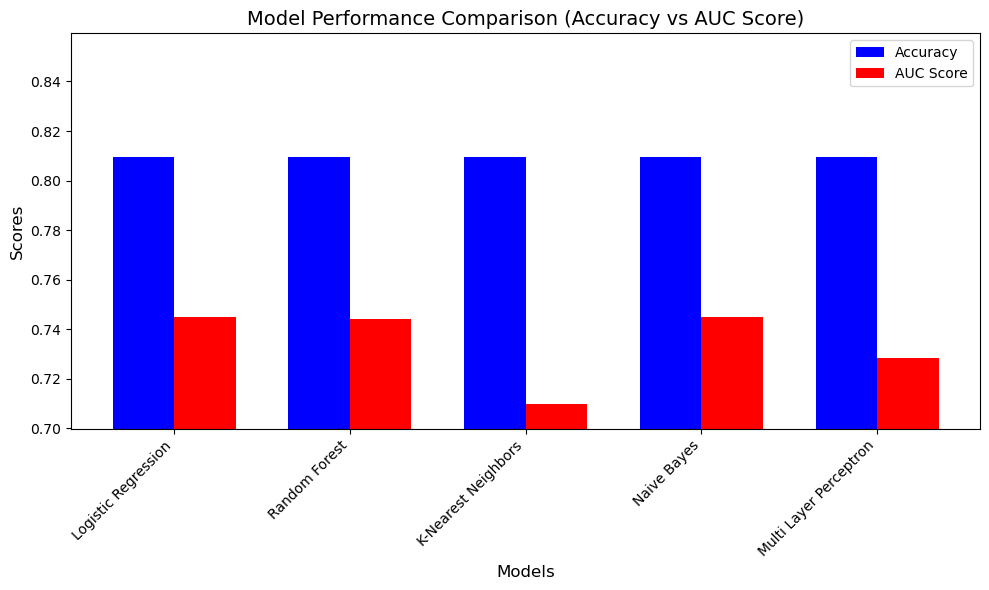

In [89]:
# Plotting accuracies of models after feature selection
featured_bar_plot = plot_bar(featured_data)

Logistic Regression, Random Forest, and Naive Bayes exhibit similar AUC scores (~0.74) but differ slightly in accuracy.
Random Forest shows slightly higher accuracy compared to others, which could make it the preferred choice if accuracy is prioritized.
K-Nearest Neighbors has a considerably lower AUC score.
Multi-Layer Perceptron has a decent accuracy but a lower AUC, suggesting its predictions may be less reliable for imbalanced data. 

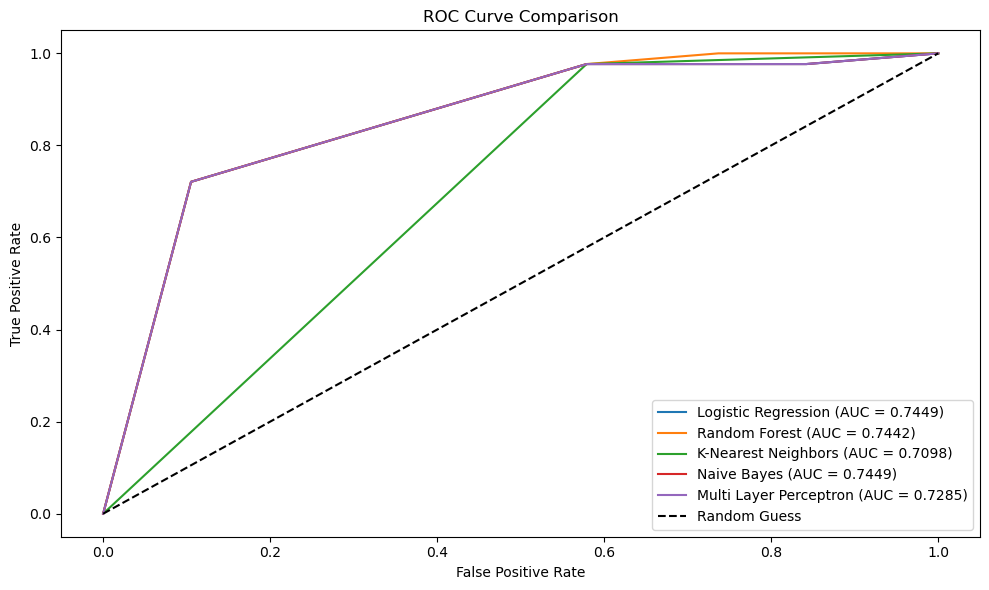

In [91]:
#Plotting models after feature selection
featured_roc_plot = plot_roc( featured_model_auc_scores, featured_model_fpr_tpr)

The ROC curve shows a close performance between Logistic Regression, Random Forest, and Naive Bayes, each achieving an AUC of approximately 0.7449.
K-Nearest Neighbors (AUC = 0.7098) has noticeably lower performance compared to the others.
Multi-Layer Perceptron (AUC = 0.7280) performs moderately but does not outperform simpler models like Logistic Regression.
The Random Guess indicates the baseline, and all classifiers perform significantly better.

After feature selection, the AUC scores improved slightly for most classifiers:

Logistic Regression: From 0.7289 (all features) to 0.7449 (selected features).
Random Forest: From 0.7548 to 0.7442 (a slight decrease of 1%).
Naive Bayes: A noticable increase from 0.7006 to 0.7449.
Multi-Layer Perceptron: From 0.7523 to 0.7280 (a slight drop).
K-Nearest Neighbors: A noticable increase from 0.6843 to 0.7098.

**Insights:** 
Feature selection particularly benefited Naive Bayes and K-Nearest Neighbors. However, the performance of models like Random Forest and Multi-Layer Perceptron, was relatively stable or slightly reduced.
Feature selection has a stabilizing effect for simpler models like Logistic Regression and Naive Bayes. These models rely heavily on relevant input features, and eliminating noise appears to have enhanced their discriminative power.
Complex models (e.g., Random Forest and MLP) saw minimal changes in AUC, suggesting they were already robust to irrelevant features.

Accuracy scores across all models remained relatively high after feature selection. However:
There is a noticeable alignment between AUC and accuracy for Logistic Regression, Naive Bayes, and Random Forest, indicating feature selection improved the reliability of predictions.
The discrepancy between accuracy and AUC for K-Nearest Neighbors highlights that its high accuracy could be misleading due to imbalanced data or threshold issues. Feature selection improved its AUC while maintaining reasonable accuracy.


Feature selection appears to have eliminated irrelevant or noisy features, benefiting simpler models like Naive Bayes and Logistic Regression significantly.

K-Nearest Neighbors saw a substantial improvement in AUC after feature selection, reflecting its sensitivity to high-dimensional spaces.

For models like Random Forest and MLP, which already manage irrelevant features well, the marginal drop in AUC suggests that some removed features might have contained subtle predictive power.

#  Hyperparameter tuning

Logistic regression and Naive bayes have the same accuracy and AUC scores. Both have been compared to see which one gives better results

In [96]:
# hyperparameter grid
#parameters for naive bayes
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
#parameters for logistic regression
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [200,100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)

In [166]:
def tuning_model(param, estimator):
    """
    Tune a machine learning model using GridSearchCV for hyperparameter optimization
    before and after feature selection, based on the AUC score and accuracy.

    Parameters:
    -----------
    param : dict
        Dictionary containing hyperparameter grid to search.

    estimator : sklearn estimator
        The machine learning model (e.g., RandomForestClassifier, LogisticRegression) to be tuned.

    Returns:
    --------
    None
        Prints the best accuracy and AUC scores before and after feature selection.
    """
    
    # Define the scoring metric: Area Under the ROC Curve (AUC)
    # needs_proba=True ensures that the method uses predicted probabilities for scoring
    scorer = make_scorer(roc_auc_score, needs_proba=True)
    
    # Perform Grid Search before feature selection
    print("Starting GridSearchCV before feature selection...")
    grid_search_auc_before = GridSearchCV(
        estimator=estimator,  # Model to optimize
        param_grid=param,     # Hyperparameter grid
        scoring=scorer,       # Use AUC as the evaluation metric
        cv=5,                 # 5-fold cross-validation
        verbose=1             # Display progress during the search
    )
    grid_search_accuracy_before = GridSearchCV(
        estimator=estimator,  # Model to optimize
        param_grid=param,     # Hyperparameter grid
        scoring='accuracy',       # Use AUC as the evaluation metric
        cv=5,                 # 5-fold cross-validation
        verbose=1             # Display progress during the search
    )
    
    # Fit the model on the original dataset (before feature selection)
    grid_search_auc_before.fit(X, y)
    grid_search_accuracy_before.fit(X, y)
    
    # Get the best hyperparameters and corresponding AUC score
    best_score_accuracy_before = grid_search_accuracy_before.best_score_
    best_score_auc_before = grid_search_auc_before.best_score_
    
    print("Best Accuracy score (Before Feature Selection):", best_score_accuracy_before)
    print("Best AUC Score (Before Feature Selection):", best_score_auc_before)
    
    # Perform Grid Search after feature selection
    print("\nStarting GridSearchCV after feature selection...")
    grid_search_auc_after = GridSearchCV(
        estimator=estimator,  # Model to optimize
        param_grid=param,     # Hyperparameter grid
        scoring=scorer,       # Use AUC as the evaluation metric
        cv=5,                 # 5-fold cross-validation
        verbose=1             # Display progress during the search
    )
    grid_search_accuracy_after = GridSearchCV(
        estimator=estimator,  # Model to optimize
        param_grid=param,     # Hyperparameter grid
        scoring='accuracy',   # Use accuracy as the evaluation metric
        cv=5,                 # 5-fold cross-validation
        verbose=1             # Display progress during the search
    )
    # Fit the model on the reduced dataset (after feature selection)
    grid_search_auc_after.fit(X_featured, y)
    grid_search_accuracy_after.fit(X_featured, y)
    
    # Get the best hyperparameters and corresponding AUC score
    best_score_accuracy_after = grid_search_accuracy_after.best_score_
    best_score_auc_after = grid_search_auc_after.best_score_
    
    print("Best Accuracy Score (After Feature Selection):", best_score_accuracy_after)
    print("Best AUC Score (After Feature Selection):", best_score_auc_after)


In [168]:
#tuning logistic regression
tuning_model(grid,log)

Starting GridSearchCV before feature selection...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Accuracy score (Before Feature Selection): 0.809462881514061
Best AUC Score (Before Feature Selection): 0.7519513338398787

Starting GridSearchCV after feature selection...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Accuracy Score (After Feature Selection): 0.809462881514061
Best AUC Score (After Feature Selection): 0.7444661143809751


In [170]:
#tuning naive bayes
tuning_model(param_grid,nb)

Starting GridSearchCV before feature selection...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Accuracy score (Before Feature Selection): 0.809462881514061
Best AUC Score (Before Feature Selection): 0.7539991192158375

Starting GridSearchCV after feature selection...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Accuracy Score (After Feature Selection): 0.809462881514061
Best AUC Score (After Feature Selection): 0.7444661143809751


For both models, the accuracy scores remains 0.8094, indicating that feature selection did not significantly impact the overall classification performance. This suggests that the removed features were not contributing substantially to the classification accuracy.

The AUC scores dropped slightly to 0.7445, compared to the AUC scores before feature selection. This reduction in AUC might indicate that some features removed during feature selection contained information that was useful for separating the positive and negative classes.

Overall, feature selection helped simplify the model by retaining only the most relevant features, maintaining accuracy.